In [1]:
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (2273/2273), done.
/kaggle/working/yolov5


In [2]:
!mkdir -p Dataset/FaceMask/Images
!mkdir -p Dataset/FaceMask/Labels

In [3]:
!cp -rf /kaggle/input/face-mask-detection/images/* Dataset/FaceMask/Images

In [4]:
!mkdir -p Dataset/images Dataset/labels

In [5]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [6]:
#creates dataset
FILE_ROOT = "/kaggle/input/face-mask-detection/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
LABELS_ROOT = DATA_ROOT + "FaceMask/Labels"
IMAGES_ROOT = DATA_ROOT + "FaceMask/Images"  

DEST_IMAGES_PATH = "images"
DEST_LABELS_PATH = "labels" 

In [7]:
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

In [8]:
#converts xml annotation to darknet format coordinates
def cord_converter(size, box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])
    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))
    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [9]:
def save_file(img_jpg_file_name, size, img_box):
    save_file_name = LABELS_ROOT + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:
        cls_num = classes.index(box[0])
        new_box = cord_converter(size, box[1:])
        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")
    file_path.flush()
    file_path.close()

In [10]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)
    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    save_file(img_xml_file, [img_w, img_h], img_box)

In [11]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
Dataset/FaceMask/Labels/maksssksksss737.txt
file name:  maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
Dataset/FaceMask/Labels/maksssksksss410.txt
file name:  maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
Dataset/FaceMask/Labels/maksssksksss537.txt
file name:  maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
Dataset/FaceMask/Labels/maksssksksss295.txt
file name:  maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
Dataset/FaceMask/Labels/maksssksksss771.txt
file name:  maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
Dataset/FaceMask/Labels/maksssksksss234.txt
file name:  maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
Dataset/FaceMask/Labels/maksssksksss620.txt
file n

In [12]:
#splits image datasets into train,valid and test
from sklearn.model_selection import train_test_split
image_list = os.listdir('Dataset/FaceMask/Images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=7)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=8)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

total = 853
train : 682
val   : 85
test  : 86


In [13]:
def copy_data(file_list, img_labels_root, imgs_source, type):
    root_file = Path(DATA_ROOT + DEST_IMAGES_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} does not exist")
        os.makedirs(root_file)
    root_file = Path(DATA_ROOT + DEST_LABELS_PATH + '/' + type)
    if not root_file.exists():
        print(f"Path {root_file} does not exist")
        os.makedirs(root_file)
    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'
        label_src_file = img_labels_root + '/' + img_name + '.txt'
        #copies image
        DICT_DIR = DATA_ROOT + DEST_IMAGES_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.png'
        copyfile(img_src_file, img_dict_file)
        #copies label
        DICT_DIR = DATA_ROOT + DEST_LABELS_PATH + '/' + type
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [14]:
copy_data(train_list, LABELS_ROOT, IMAGES_ROOT, "train")
copy_data(val_list,   LABELS_ROOT, IMAGES_ROOT, "val")
copy_data(test_list,  LABELS_ROOT, IMAGES_ROOT, "test")

Path Dataset/images/train does not exist
Path Dataset/labels/train does not exist
Path Dataset/images/val does not exist
Path Dataset/labels/val does not exist
Path Dataset/images/test does not exist
Path Dataset/labels/test does not exist


In [15]:
#yaml files define how and where the directories are structured
!echo "train: Dataset/images/train" > data/facemask.yaml
!echo "val:   Dataset/images/val" >> data/facemask.yaml
!echo "nc : 3" >> data/facemask.yaml
!echo "names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']" >> data/facemask.yaml
!cat data/facemask.yaml

train: Dataset/images/train
val:   Dataset/images/val
nc : 3
names: ['With_Mask', 'Without_Mask', 'Incorrect_Mask']


In [16]:
#train
!python train.py --img 320 --batch 20 --epochs 300 --data data/facemask.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

2021-10-02 15:18:42.773496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
100%|███████████████████████████████████████| 14.5M/14.5M [00:00<00:00, 133MB/s]

Scanning 'Dataset/labels/train' for images and labels... 682 found, 0 missing, 0
Scanning 'Dataset/labels/train.cache' for images and labels... 682 found, 0 miss
Scanning 'Dataset/labels/val' for images and labels... 85 found, 0 missing, 0 em
Scanning 'Dataset/labels/val.cache' for images and labels... 85 found, 0 missing
Scanning 'Dataset/labels/val.cache' for images and labels... 85 found, 0 missing

Scanning 'Dataset/labels/val.cache' for images and labels... 85 found, 0 missing
anchors/target = 4.33, Best Possible Recall (BPR) = 0.9970
     0/299     1.23G    0.1236    0.1025   0.03505    0.2612        11       320
               Class      Images     Targets           P           R      mAP@.5
                 all          85         399       0.333     0.0

In [17]:
#save trained weights
!cp runs/train/exp/weights/best.pt weights

In [18]:
!python detect.py --source Dataset/images/test --img-size 320 --conf 0.6 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='Dataset/images/test', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
image 1/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss0.png: 256x320 1 With_Masks, 2 Without_Masks, Done. (0.030s)
image 2/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss106.png: 224x320 Done. (0.030s)
image 3/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss107.png: 320x256 1 With_Masks, Done. (0.031s)
image 4/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss108.png: 192x320 4 With_Masks, 1 Without_Masks, Done. (0.030s)
image 5/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss112.png: 320x224 1 Incorrect_Masks, Done. (0.033s)
image 6/86 /kaggle/working/yolov5/Dataset/images/test/maksssksksss118.png: 224x320 2 With_Masks, Done. (0.024s

In [19]:
#library to display detected images
from IPython.display import Image

In [20]:
!python detect.py --source /kaggle/input/input-images/facemask.jpg --img-size 320 --conf 0.6 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/input/input-images/facemask.jpg', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
image 1/1 /kaggle/input/input-images/facemask.jpg: 160x320 28 With_Masks, Done. (0.029s)
Results saved to runs/detect/exp2
Done. (0.116s)


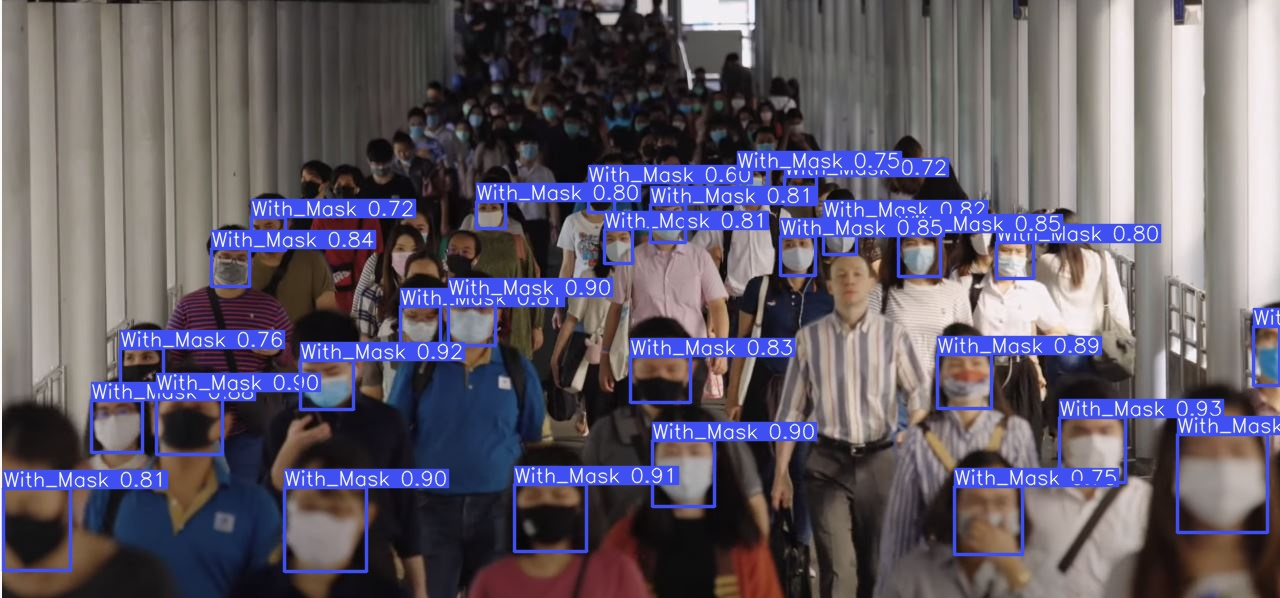

In [21]:
Image('runs/detect/exp2/facemask.jpg')

In [22]:
!python detect.py --source /kaggle/input/input-images/facemask1.jpg --img-size 320 --conf 0.6 --weights weights/best.pt 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.6, device='', exist_ok=False, img_size=320, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/kaggle/input/input-images/facemask1.jpg', update=False, view_img=False, weights=['weights/best.pt'])
Fusing layers... 
image 1/1 /kaggle/input/input-images/facemask1.jpg: 160x320 1 With_Masks, 3 Without_Masks, Done. (0.031s)
Results saved to runs/detect/exp3
Done. (0.092s)


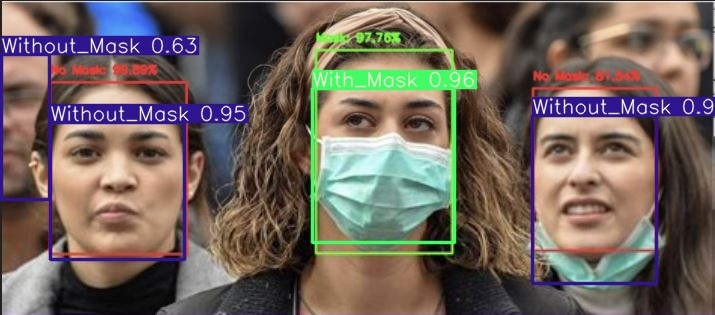

In [23]:
Image('runs/detect/exp3/facemask1.jpg')

In [24]:
#from utils.plots import plot_results 
#plot_results('./yolov5/runs/train/exp/results.png') 